In [1]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading CVS data-set
loan_data = pd.read_csv("loan.csv")
print(loan_data.shape)
loan_data.head()

(39717, 111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
# Drop those rows which has active loan account, as they won't help in deciding defaulter
curr_idx = loan_data.loc[loan_data.loc[:, "loan_status"] == "Current"].index
loan_data.drop(index=curr_idx, inplace=True)

In [4]:
# Remove columns with all null values
loan_data.dropna(axis = 1, how = 'all', inplace = True)
loan_data.shape

(38577, 56)

In [5]:
# Remove colums with single values
loan_data.drop(columns=loan_data.columns[loan_data.nunique() <= 1], inplace=True)
print(loan_data.shape)

(38577, 45)


In [6]:
# Make bin for emp_length
loan_data.loc[loan_data["emp_length"] == "< 1 year", "emp_length"] = "0 year"
loan_data["emp_length"] = loan_data["emp_length"].str.replace("years", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("year", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("<", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("+", "")
loan_data["emp_length"] = pd.to_numeric(loan_data["emp_length"])
loan_data["emp_length"].describe()

count    37544.000000
mean         4.940976
std          3.557082
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

In [7]:
# Create numeric data for int_rate & revol_util
for val in ("int_rate", "revol_util"):
    loan_data[val] = pd.to_numeric(loan_data[val].str.replace("%", ""))

In [8]:
# Mark verified 1 if verification_status is not "Not Verified"
loan_data.loc[loan_data["verification_status"] == "Not Verified", "verified"] = 0
loan_data.loc[loan_data["verification_status"] == "Verified", "verified"] = 1
loan_data.loc[loan_data["verification_status"] == "Source Verified", "verified"] = 2
loan_data.drop(columns=["verification_status"], inplace=True)
loan_data["verified"].value_counts()

0.0    16694
1.0    12206
2.0     9677
Name: verified, dtype: int64

In [9]:
# Marking whether term is 36 or not.
loan_data["term_in_months"] = pd.to_numeric(loan_data["term"].str.replace("months", ""))
loan_data.loc[loan_data["term_in_months"] == 36, "term_36_not60"] = 1
loan_data.loc[loan_data["term_in_months"] == 60, "term_36_not60"] = 0
loan_data.drop(columns=["term", "term_in_months"], inplace=True)
print(loan_data["term_36_not60"].value_counts())

1.0    29096
0.0     9481
Name: term_36_not60, dtype: int64


In [10]:
# Marking whether loan is paid or not
loan_data.loc[loan_data["loan_status"] == "Charged Off", "loan_paid"] = 0
loan_data.loc[loan_data["loan_status"] == "Fully Paid", "loan_paid"] = 1
loan_data.drop(columns=["loan_status"], inplace=True)
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies', 'verified',
       'term_36_not60', 'loan_paid'],
      dtype='object')

## Processing Null data for relevant fields

In [11]:
loan_data.isnull().sum()

id                             0
member_id                      0
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_title                   2386
emp_length                  1033
home_ownership                 0
annual_inc                     0
issue_d                        0
url                            0
desc                       12527
purpose                        0
title                         11
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq     24905
mths_since_last_record     35837
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                    50
total_acc 

In [12]:
# pub_rec & pub_rec_bankruptcies both are closely connected.
print((loan_data["pub_rec"] - loan_data["pub_rec_bankruptcies"]).value_counts())
# Most of the value present in pub_rec is 0.
print(loan_data["pub_rec"].value_counts())

0.0    37472
1.0      357
2.0       42
3.0        7
4.0        2
dtype: int64
0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64


In [13]:
# Thus pub_rec & pub_rec_bankruptcies both can be dropped.
loan_data.drop(columns=["pub_rec", "pub_rec_bankruptcies"], inplace=True)

In [14]:
# Too many null data, thus can be dropped
loan_data.drop(columns=["mths_since_last_delinq", "mths_since_last_record"], inplace=True)

In [15]:
print((loan_data.loc[loan_data["loan_paid"] == 1, "emp_length"]).describe())
print((loan_data.loc[loan_data["loan_paid"] == 0, "emp_length"]).describe())

count    32145.000000
mean         4.917468
std          3.549112
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64
count    5399.000000
mean        5.080941
std         3.601326
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        10.000000
Name: emp_length, dtype: float64


In [16]:
loan_data.loc[(loan_data["loan_paid"] == 1) & (loan_data["emp_length"].isna()), "emp_length"] = 4
loan_data.loc[(loan_data["loan_paid"] == 0) & (loan_data["emp_length"].isna()), "emp_length"] = 5

## Deriving new columns

In [17]:
# Creating credit-age, to replace earliest_cr_line
# Creating issue_d_year & issue_d_month, to replace issue_d
for attr in ("earliest_cr_line", "issue_d"):
    loan_data[f"{attr}_year"] = loan_data[attr].apply(lambda x: 
        (1900+int(x.split('-')[1]) if int(x.split('-')[1])>50 else (2000+int(x.split('-')[1]))))
    loan_data[f"{attr}_month"] = loan_data[attr].apply(lambda x: x.split('-')[0])

loan_data["credit_age"] = pd.to_datetime(loan_data["issue_d_year"].astype(str) + '/' + loan_data["issue_d_month"] + '/' + '01').dt.to_period('M').astype(int) - \
    pd.to_datetime(loan_data["earliest_cr_line_year"].astype(str) + '/' + loan_data["earliest_cr_line_month"] + '/' + '01').dt.to_period('M').astype(int)
loan_data.drop(columns=["earliest_cr_line", "earliest_cr_line_year", "earliest_cr_line_month", "issue_d"], inplace=True)
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'verified',
       'term_36_not60', 'loan_paid', 'issue_d_year', 'issue_d_month',
       'credit_age'],
      dtype='object')

In [18]:
# Removing bad data, as credit-age can't be negative
loan_data.drop(index=loan_data.index[loan_data["credit_age"] < 0], inplace=True)
loan_data.shape

(38575, 42)

In [19]:
# Creating closed-account to replace total_acc
loan_data["closed_acc"] = loan_data["total_acc"] - loan_data["open_acc"]
loan_data.drop(columns=["total_acc"], inplace=True)
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'verified',
       'term_36_not60', 'loan_paid', 'issue_d_year', 'issue_d_month',
       'credit_age', 'closed_acc'],
      dtype='object')

## Variables those can be dropped
##### id , member_id, emp_title, url, desc, zip_code, addr_state, funded_amnt (as funded_amnt_inv is present), title (as purpose is present), 

In [20]:
# Dropping columns mentioned above
loan_data.drop(columns=["id" , "member_id", "emp_title", "url", "desc", "zip_code", "addr_state", "funded_amnt", "title"], inplace=True)
print(loan_data.shape)
loan_data.columns

(38575, 33)


Index(['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal',
       'revol_util', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'verified', 'term_36_not60', 'loan_paid',
       'issue_d_year', 'issue_d_month', 'credit_age', 'closed_acc'],
      dtype='object')

## Removing skewed data

percentile: 0.94
percentile: 0.93
percentile: 0.9


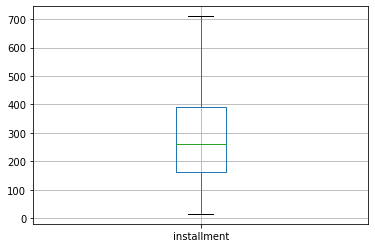

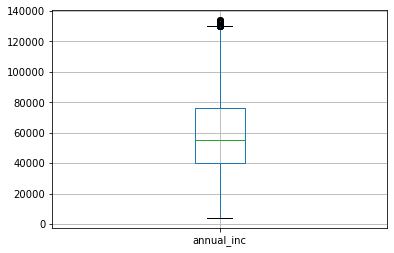

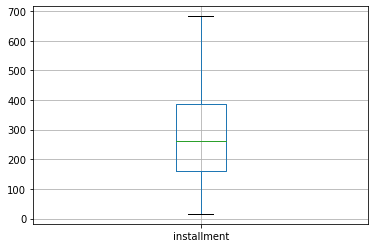

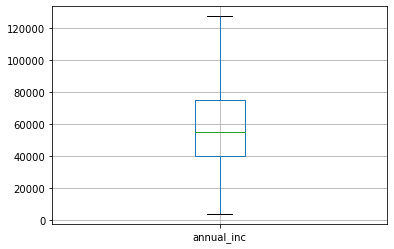

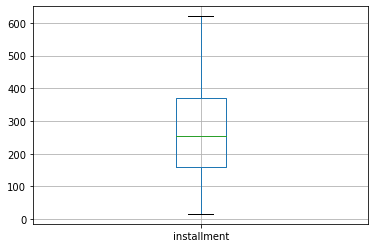

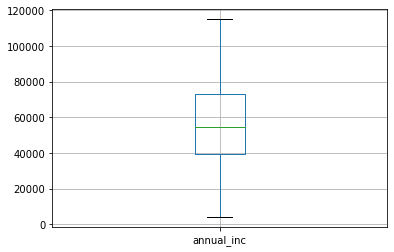

In [21]:
# Used this code to find quantile to remove skewed data from a numeric continuous data
def getBoxPlot(df: pd.DataFrame, percentile: float) -> None:
    # for attr in ("loan_amnt", "int_rate", "installment", "annual_inc", "dti", "open_acc", "closed_acc"):
    for attr in ("installment", "annual_inc",):
        plt.figure()
        (df.loc[df[attr] < df[attr].quantile(percentile)]).boxplot(attr)

# for x in (1.0, 0.99, 0.98, 0.97):
for x in (0.94, 0.93, 0.9):
    print(f"percentile: {x}")
    getBoxPlot(loan_data, x)

In [22]:
# Using this qunatile info to generate new dataset, for processing
loan = loan_data.loc[(loan_data["loan_amnt"] < loan_data["loan_amnt"].quantile(0.98)) & 
              (loan_data["int_rate"] < loan_data["int_rate"].quantile(0.99)) &
              (loan_data["installment"] < loan_data["installment"].quantile(0.94)) &
              (loan_data["annual_inc"] < loan_data["annual_inc"].quantile(0.93))]
loan.shape

(33829, 33)

## Creating bins for numeric continuous data

In [23]:
# Functions to create 10 different bins for a column
def bucketting(df: pd.DataFrame, title: str, cutDict: dict) -> None:
    if title not in df.columns:
        print(f"{title} not present in provided data-frame")
        return
    cutOut = pd.cut(df[title], bins=10, precision=0, labels=[ f"{title[0:3]}_{str(i)}" for i in range(1,11)], retbins=True)
    df[f'{title}_groups'] = cutOut[0]
    cutDict[title] = cutOut[1]

In [24]:
# Bucketting of numeric continuous data while keeping the numeric data as well
cutRange = {}
for title in ("loan_amnt", "int_rate", "installment", "annual_inc",
              "dti", "credit_age", "closed_acc", "open_acc",
              "funded_amnt_inv", "revol_util"):
    bucketting(loan, title, cutRange)
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33829 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   loan_amnt                33829 non-null  int64   
 1   funded_amnt_inv          33829 non-null  float64 
 2   int_rate                 33829 non-null  float64 
 3   installment              33829 non-null  float64 
 4   grade                    33829 non-null  object  
 5   sub_grade                33829 non-null  object  
 6   emp_length               33829 non-null  float64 
 7   home_ownership           33829 non-null  object  
 8   annual_inc               33829 non-null  float64 
 9   purpose                  33829 non-null  object  
 10  dti                      33829 non-null  float64 
 11  delinq_2yrs              33829 non-null  int64   
 12  inq_last_6mths           33829 non-null  int64   
 13  open_acc                 33829 non-null  int64   
 14  revol_

### Removing sub-categories with very less data
##### Got this info while doing Univariate analysis

In [25]:
'''
Too less data for G under grade
Too less data for NONE under home_ownership
Too less data for OTHER under home_ownership
Too less data for renewable_energy under purpose
Too less data for 4 under inq_last_6mths
Too less data for 5 under inq_last_6mths
Too less data for 6 under inq_last_6mths
Too less data for 7 under inq_last_6mths
Too less data for 8 under inq_last_6mths
'''
loan.drop(index=loan.index[loan["home_ownership"] == 'NONE'], inplace=True)
loan.drop(index=loan.index[loan["home_ownership"] == 'OTHER'], inplace=True)
loan.drop(index=loan.index[loan["inq_last_6mths"] >= 4], inplace=True)

# Univariate & Segmented Univariate Analysis

In [26]:
def getOrderedList(allVals: list) -> list:
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    if type(allVals[0]) == str and (allVals[0].split('_')[-1]).isdigit():
        sortedAllVals = sorted(allVals, key=lambda d: int(d.split('_')[-1]))
    else:
        if allVals[0] in months:
            sortedAllVals = months
        else:
            sortedAllVals = sorted(allVals)
    return sortedAllVals

Too less data for fun_10 under funded_amnt_inv_groups
Too less data for G under grade
Too less data for F3 under sub_grade
Too less data for F4 under sub_grade
Too less data for F5 under sub_grade
Too less data for G1 under sub_grade
Too less data for G2 under sub_grade
Too less data for G3 under sub_grade
Too less data for G4 under sub_grade
Too less data for G5 under sub_grade
Too less data for renewable_energy under purpose
Too less data for 2007 under issue_d_year
Too less data for loa_10 under loan_amnt_groups
Too less data for dti_10 under dti_groups
Too less data for cre_7 under credit_age_groups
Too less data for cre_8 under credit_age_groups
Too less data for cre_9 under credit_age_groups
Too less data for cre_10 under credit_age_groups
Too less data for clo_7 under closed_acc_groups
Too less data for clo_8 under closed_acc_groups
No data for clo_9 under closed_acc_groups
Too less data for clo_10 under closed_acc_groups
Too less data for ope_6 under open_acc_groups
Too less da

<Figure size 432x288 with 0 Axes>

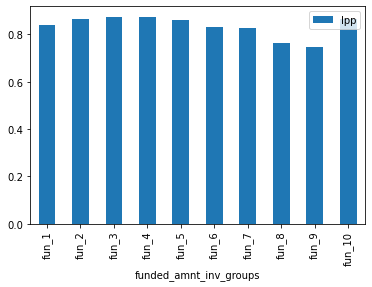

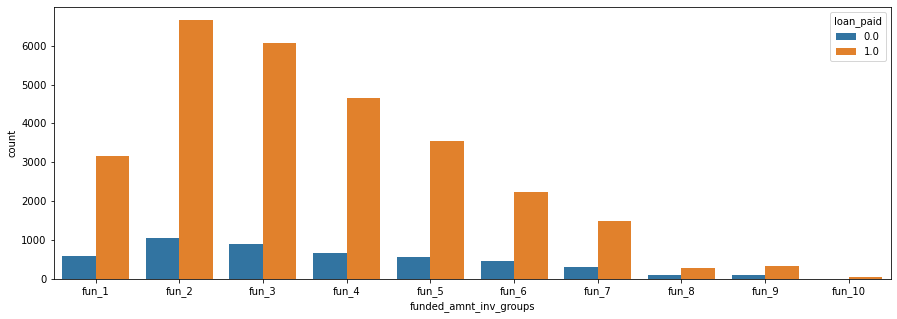

<Figure size 432x288 with 0 Axes>

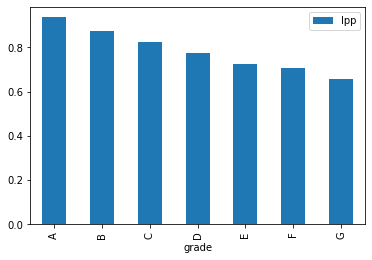

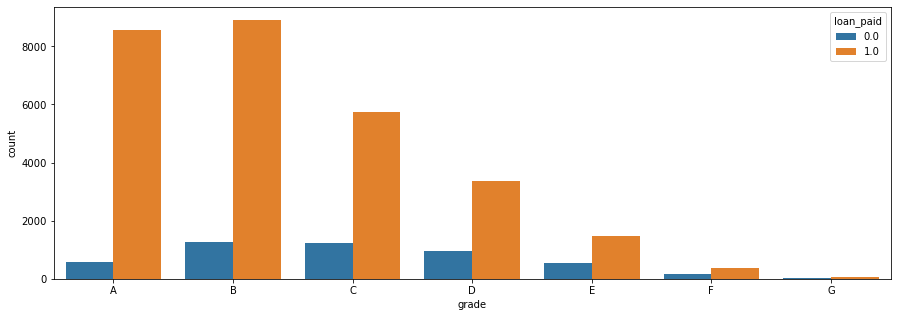

<Figure size 432x288 with 0 Axes>

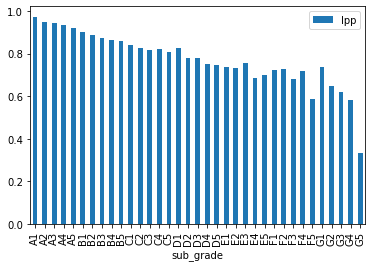

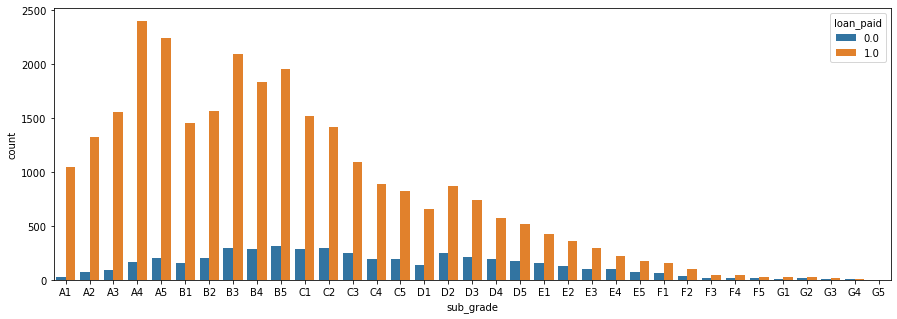

<Figure size 432x288 with 0 Axes>

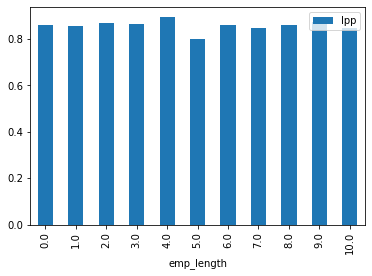

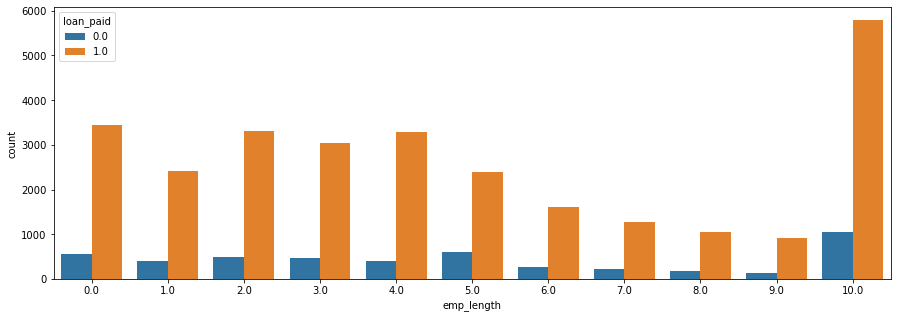

<Figure size 432x288 with 0 Axes>

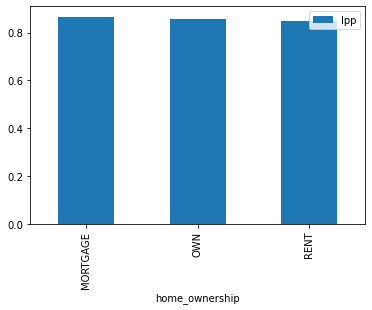

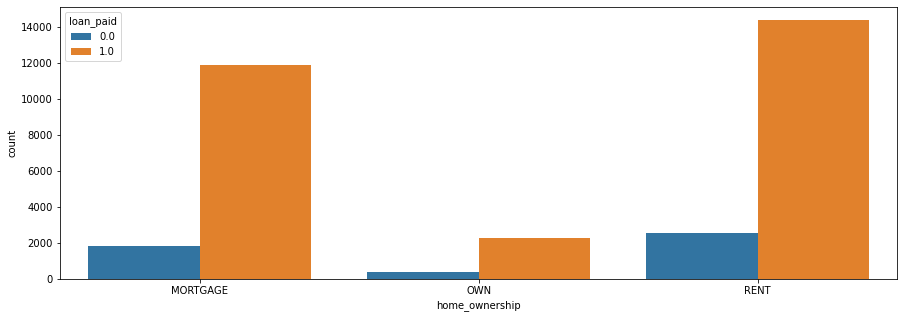

<Figure size 432x288 with 0 Axes>

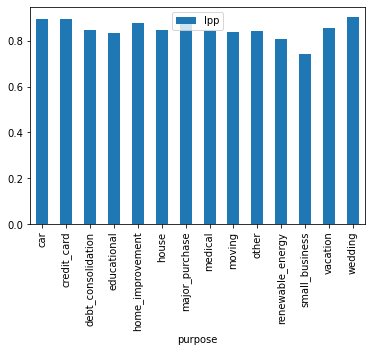

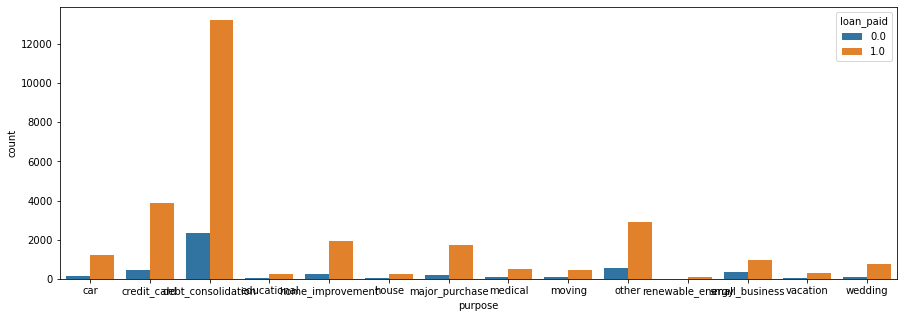

<Figure size 432x288 with 0 Axes>

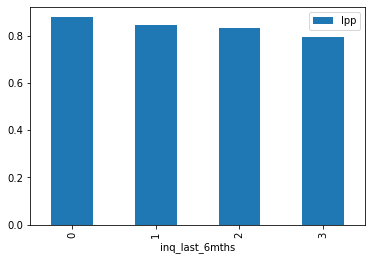

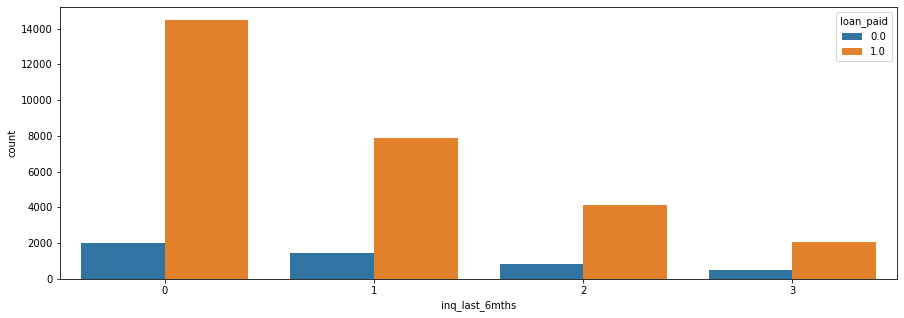

<Figure size 432x288 with 0 Axes>

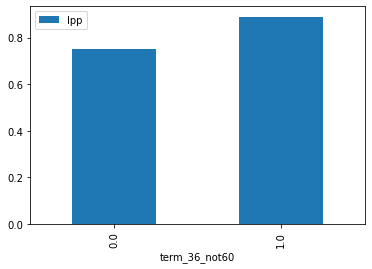

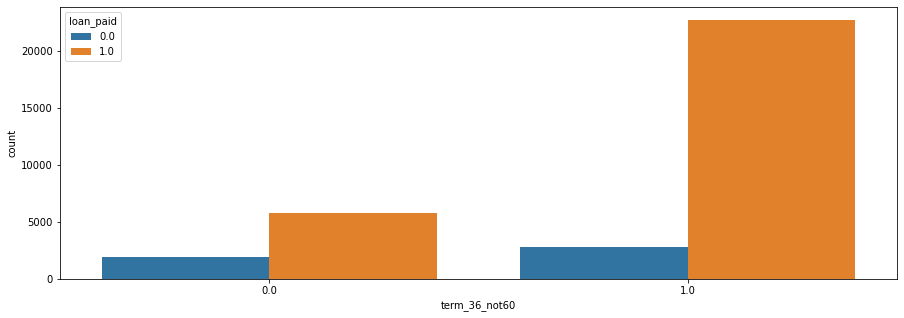

<Figure size 432x288 with 0 Axes>

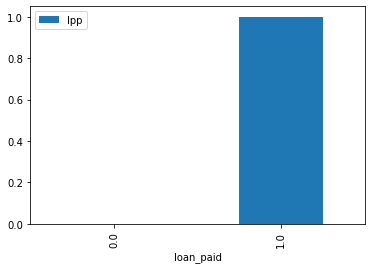

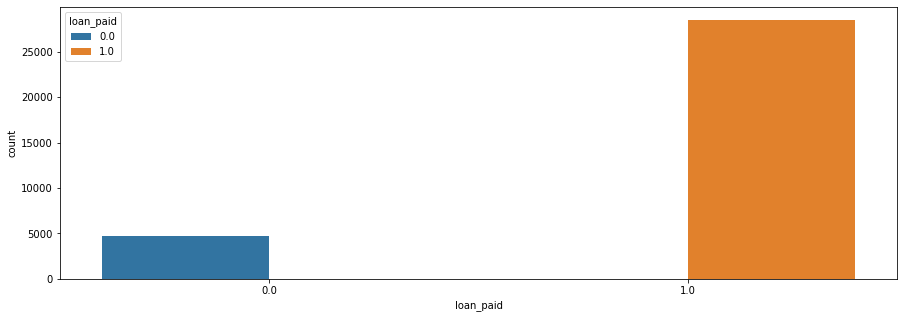

<Figure size 432x288 with 0 Axes>

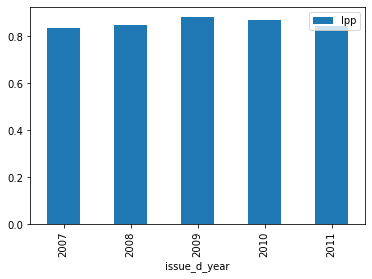

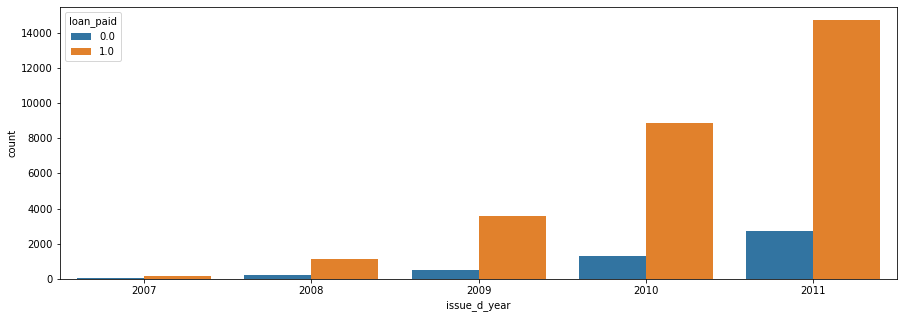

<Figure size 432x288 with 0 Axes>

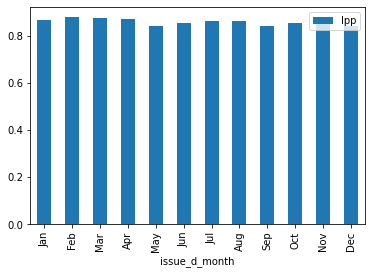

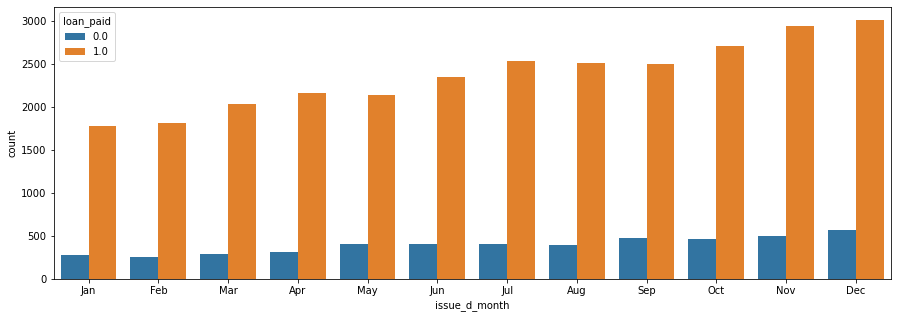

<Figure size 432x288 with 0 Axes>

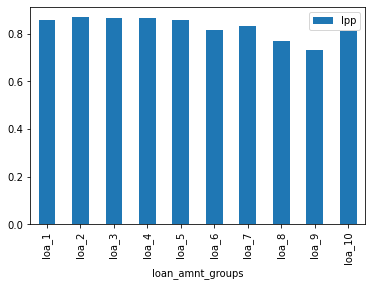

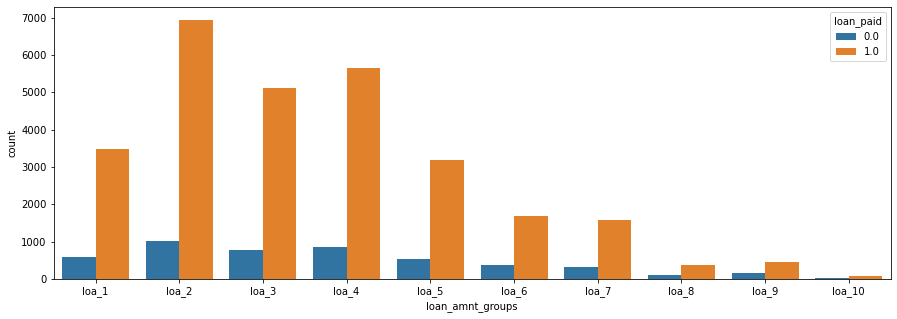

<Figure size 432x288 with 0 Axes>

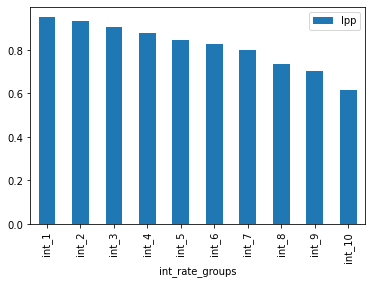

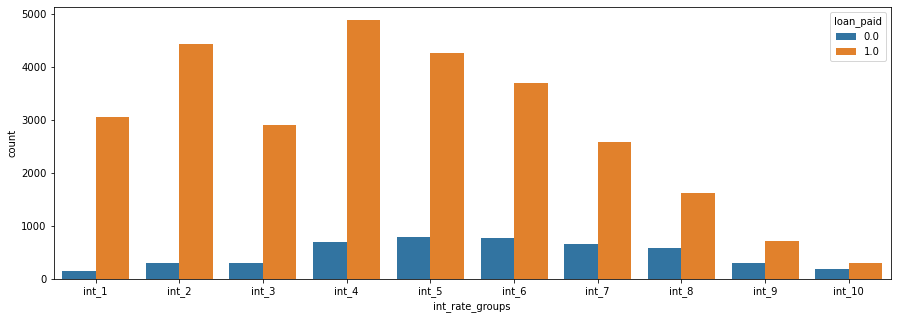

<Figure size 432x288 with 0 Axes>

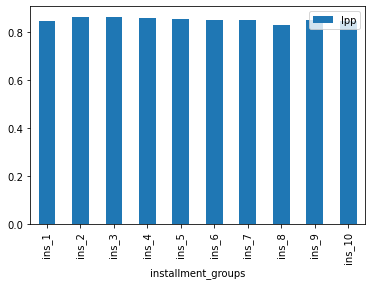

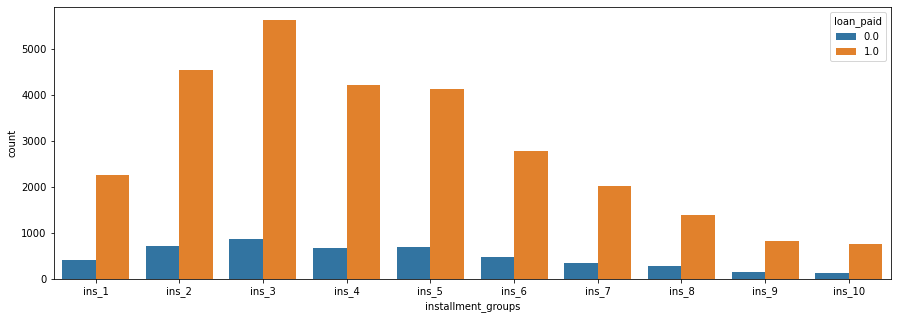

<Figure size 432x288 with 0 Axes>

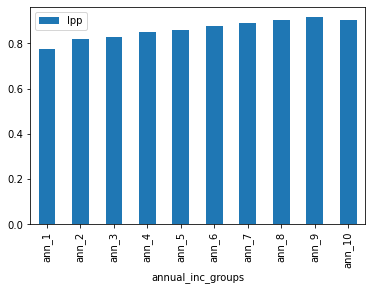

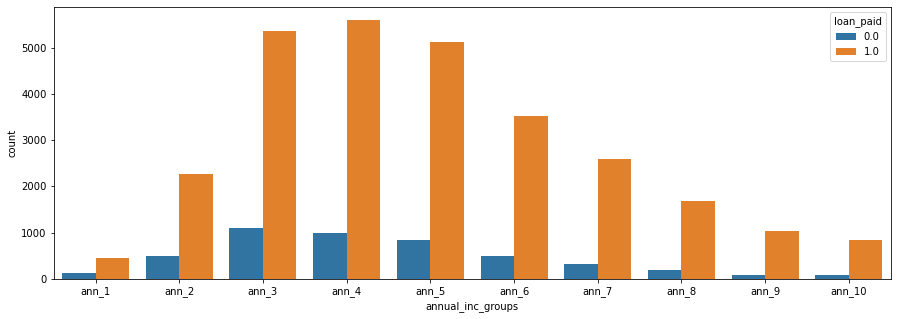

<Figure size 432x288 with 0 Axes>

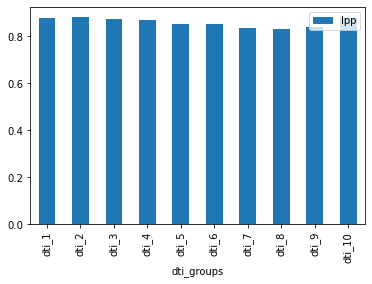

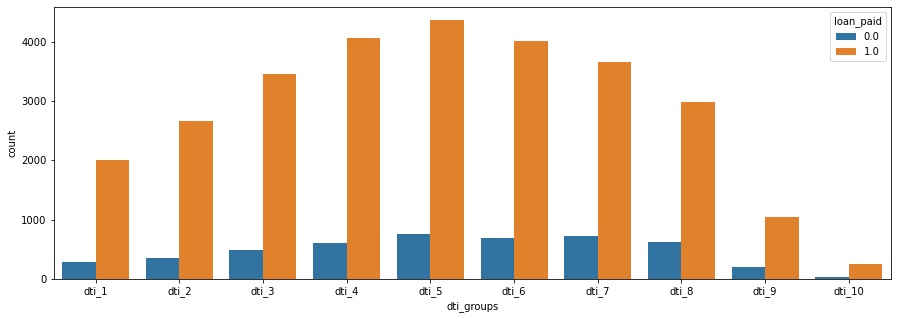

<Figure size 432x288 with 0 Axes>

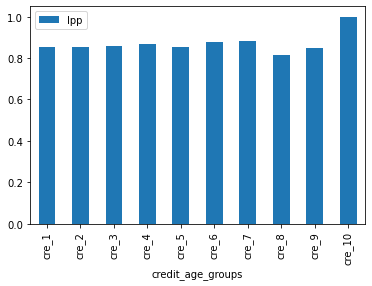

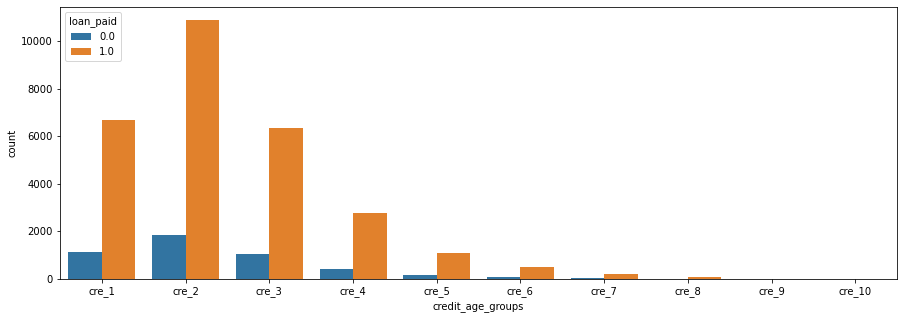

<Figure size 432x288 with 0 Axes>

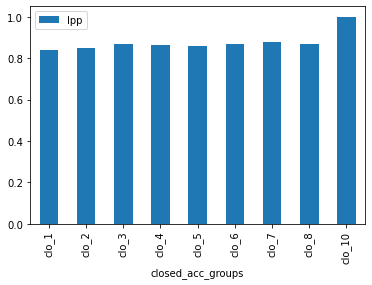

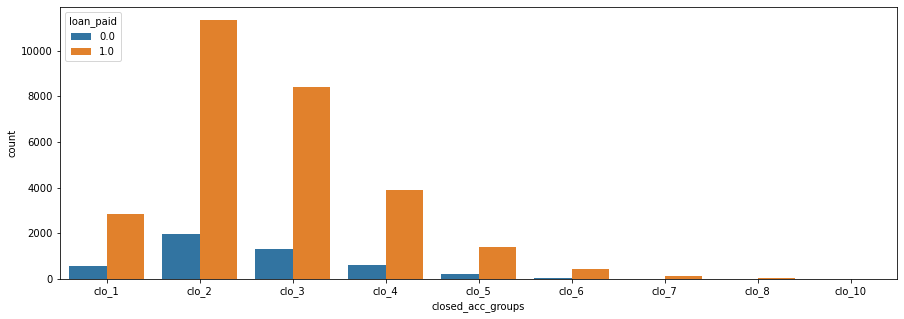

<Figure size 432x288 with 0 Axes>

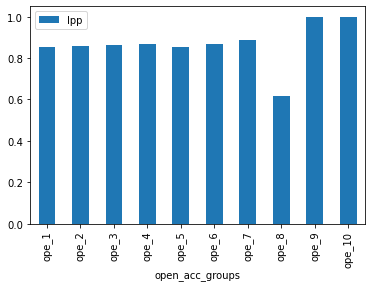

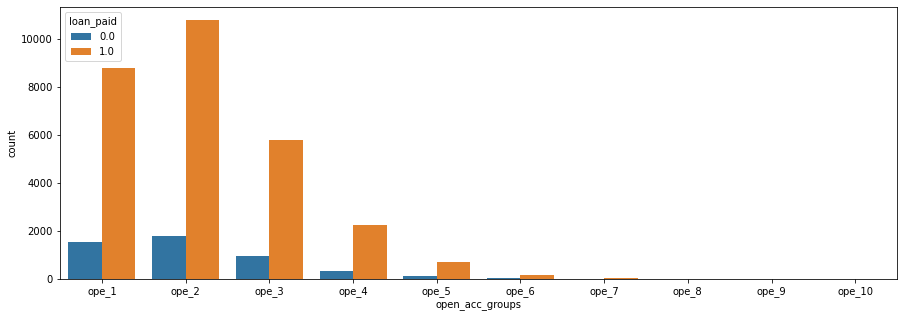

<Figure size 432x288 with 0 Axes>

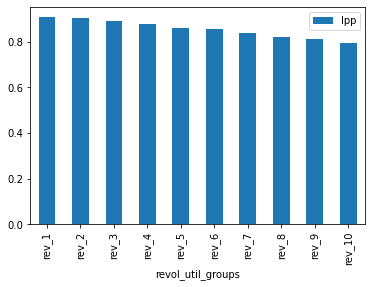

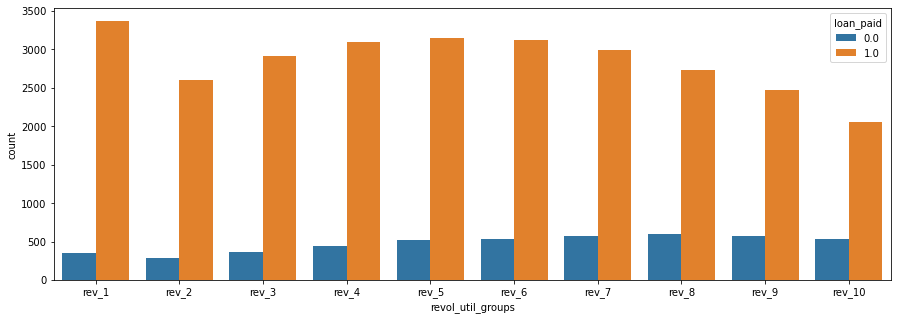

In [27]:
for attr in ("funded_amnt_inv_groups",
             "grade",
             "sub_grade",
             "emp_length",
             "home_ownership",
             "purpose",
             "inq_last_6mths",
             "term_36_not60",
             "loan_paid",
             "issue_d_year",
             "issue_d_month",
             "loan_amnt_groups",
             "int_rate_groups",
             "installment_groups",
             "annual_inc_groups",
             "dti_groups",
             "credit_age_groups",
             "closed_acc_groups",
             "open_acc_groups",
             "revol_util_groups",
    ):
    d = dict()
    sortedAllVals = getOrderedList(loan[attr].value_counts().index.values)
    for val in sortedAllVals:
        if len(loan.loc[loan[attr] == val]) == 0:
            print(f"No data for {val} under {attr}")
            continue
        elif len(loan.loc[loan[attr] == val]) < len(loan)/(10*len(loan[attr].value_counts().index.values)):
            print(f"Too less data for {val} under {attr}")
        d[val] = len(loan.loc[(loan[attr] == val) & (loan["loan_paid"] == 1)])/len(loan.loc[loan[attr] == val])
    plt.figure()
    (pd.DataFrame({attr:d.keys(), "lpp"  : d.values()})).plot.bar(x=attr, y="lpp")
    plt.figure(figsize=(15, 5))
    sns.countplot(x=attr, hue="loan_paid", data=loan, order=d.keys())

In [28]:
cutRange

{'loan_amnt': array([  470.6,  3440. ,  6380. ,  9320. , 12260. , 15200. , 18140. ,
        21080. , 24020. , 26960. , 29900. ]),
 'int_rate': array([ 5.40452,  6.968  ,  8.516  , 10.064  , 11.612  , 13.16   ,
        14.708  , 16.256  , 17.804  , 19.352  , 20.9    ]),
 'installment': array([ 14.99587,  85.103  , 154.516  , 223.929  , 293.342  , 362.755  ,
        432.168  , 501.581  , 570.994  , 640.407  , 709.82   ]),
 'annual_inc': array([  3876.596,  16340.4  ,  28680.8  ,  41021.2  ,  53361.6  ,
         65702.   ,  78042.4  ,  90382.8  , 102723.2  , 115063.6  ,
        127404.   ]),
 'dti': array([-0.02999,  2.999  ,  5.998  ,  8.997  , 11.996  , 14.995  ,
        17.994  , 20.993  , 23.992  , 26.991  , 29.99   ]),
 'credit_age': array([ 35.352, 100.8  , 165.6  , 230.4  , 295.2  , 360.   , 424.8  ,
        489.6  , 554.4  , 619.2  , 684.   ]),
 'closed_acc': array([-6.081,  2.1  , 10.2  , 18.3  , 26.4  , 34.5  , 42.6  , 50.7  ,
        58.8  , 66.9  , 75.   ]),
 'open_acc': array

# Observations (UniVariate & Segmented UniVariate Analysis)
### Indicators for loan payment:
##### Higher Grade or Sub-Grade
##### Lower interest-rate
##### Lower revolving utility percentage
##### Less enquired in last six months (inq_last_6mths).
##### Term is 36 months.
##### If purpose is "wedding", "major purchage", credit-card" & "car".

### Indicators for loan default:
##### purpose is marked as 'other'

# Bivariate Analysis

## Now that we have analyzed each of the variables and its impact on the loan-status, let us take group of variables together and and analyze their combined effect on the loan-status. These categories are based on our business understanding. The original distribution column shows the average trend in all the data and we compare that with the data after applying our conditions.

In [29]:
loan.columns

Index(['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal',
       'revol_util', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'verified', 'term_36_not60', 'loan_paid',
       'issue_d_year', 'issue_d_month', 'credit_age', 'closed_acc',
       'loan_amnt_groups', 'int_rate_groups', 'installment_groups',
       'annual_inc_groups', 'dti_groups', 'credit_age_groups',
       'closed_acc_groups', 'open_acc_groups', 'funded_amnt_inv_groups',
       'revol_util_groups'],
      dtype='object')

In [30]:
cat_var = ["grade", "sub_grade", "emp_length", "home_ownership", "purpose", "inq_last_6mths",
           "verified", "term_36_not60", "issue_d_year", "issue_d_month", "loan_amnt_groups", "int_rate_groups",
           "installment_groups", "annual_inc_groups", "dti_groups", "credit_age_groups", "funded_amnt_inv_groups",
           "revol_util_groups"]

In [31]:
colors = ["#a9fea9","#fca9a9"]
sns.set(style='whitegrid', palette=sns.color_palette(colors))
by = 'loan_status'
order = ['Fully Paid','Charged Off']
def bivariateCategoricalAna (data: pd.DataFrame, x_axis, y_axis, title=None, figsize=(8,6)) -> None:
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    pt = pd.pivot_table(data=data, values='loan_paid', index=y_axis, columns=x_axis)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

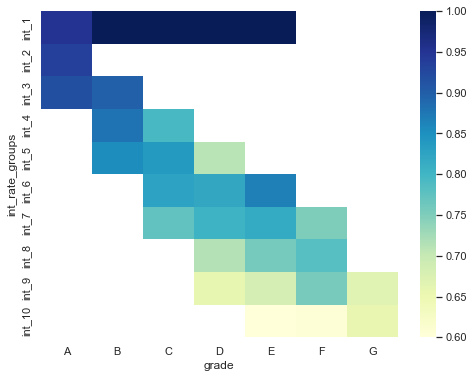

In [32]:
bivariateCategoricalAna(loan, x_axis="grade", y_axis="int_rate_groups")

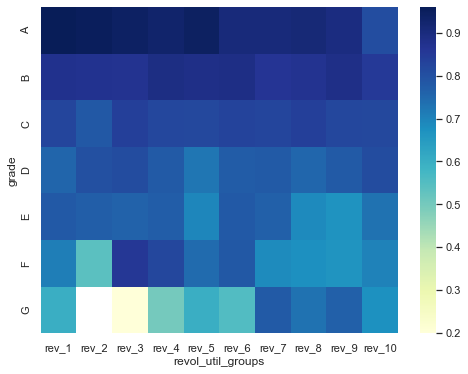

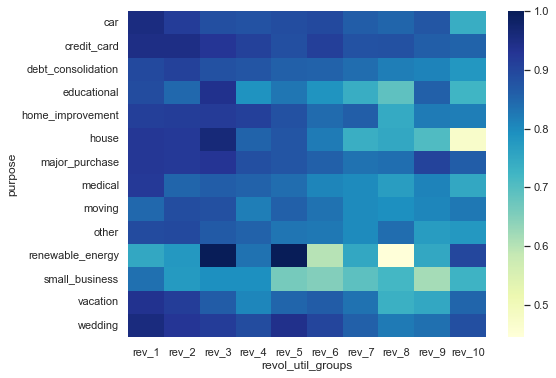

In [33]:
bivariateCategoricalAna(loan, x_axis="revol_util_groups", y_axis="grade")
bivariateCategoricalAna(loan, x_axis="revol_util_groups", y_axis="purpose")

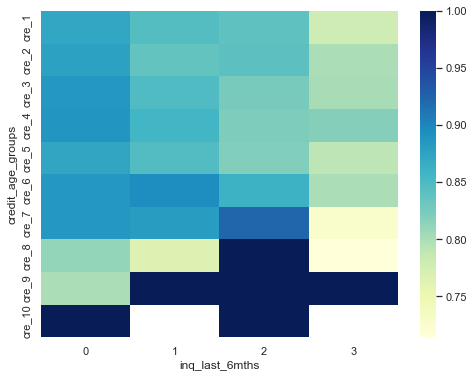

In [34]:
bivariateCategoricalAna(loan, x_axis="inq_last_6mths", y_axis="credit_age_groups")

# Observations (BiVariate Analysis)
##### - Interest-rate & grade is highly corelated : higher grade indicates lower interest rate.
##### - Grade is a strong indicator. Higher grade (A) will have high probability to pay loan.
##### - Revolving utility percentage (lower utility leads to higher loan pay probability) has low impact on "wedding", "major purchage", credit-card" & "car" purpose category.
##### In higher credit-age group (554 month +), trend for inq_last_6mths acts opposite relative to univariate analysis outcome.
##### If term is 36 months, loan-payment probability is higher as indicated by univariate analysis.
##### Higher income group(102k+) have high probability of paying loan.

In [35]:
# Used following code for bivariate analysis.
'''
# No need to look into output of this. We wanted to give a glimplse how we did bivariate
# analysis. I am sure that there must be some better way to do it.
for i in range(1, len(cat_var)):
    for j in range(1, len(cat_var)):
        if i == j:
            continue
        bivariateCategoricalAna(loan, x_axis=cat_var[i], y_axis=cat_var[j])
'''

'\n# No need to look into output of this. We wanted to give a glimplse how we did bivariate\n# analysis. I am sure that there must be some better way to do it.\nfor i in range(1, len(cat_var)):\n    for j in range(1, len(cat_var)):\n        if i == j:\n            continue\n        bivariateCategoricalAna(loan, x_axis=cat_var[i], y_axis=cat_var[j])\n'